In [1]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as transform
import os

TRAIN_TRANSFORM = transform.Compose([transform.ToTensor(),transform.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transform.Resize(size=[128,128])])
TEST_TRANSFORM = transform.Compose([transform.ToTensor(),transform.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),transform.Resize(size=[128,128])])
DATA_ROOT_DIR = '/home/qbw/dataset/cls_dataset/CIFAR10/'

DOWNLOAD_TAG  = False
if not os.path.exists(DATA_ROOT_DIR):
    os.makedirs(DATA_ROOT_DIR)
    DOWNLOAD_TAG = True

def get_loader(normalize_tag=True,bs=1024):
    assert isinstance(bs,int) or bs == 'full'
    CIFAR10_trainset = CIFAR10(root=DATA_ROOT_DIR,train=True,transform=TRAIN_TRANSFORM if normalize_tag else transform.ToTensor(),download=DOWNLOAD_TAG)
    CIFAR10_testset = CIFAR10(root=DATA_ROOT_DIR,train=False,transform=TEST_TRANSFORM if normalize_tag else transform.ToTensor(),download=DOWNLOAD_TAG)
    return DataLoader(dataset=CIFAR10_trainset,batch_size=len(CIFAR10_trainset) if bs=='full' else bs,shuffle=True,num_workers=16),\
        DataLoader(dataset=CIFAR10_testset,batch_size=len(CIFAR10_testset) if bs=='full' else bs,shuffle=False,num_workers=16)

/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18,resnet50,resnet34
import torch.nn.functional as F
from copy import deepcopy

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
SEED = 729608
# torch random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# os python hash seed, make experiment reproducable
os.environ['PYTHONHASHSEED'] = str(SEED)
# gpu algorithom 
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# Generator SEED
Generator = torch.Generator()
Generator.manual_seed(SEED)

class SoftmaxWithTemperature(nn.Module):
    def __init__(self,temp):
        super().__init__()
        self.temp = temp
    
    def forward(self,pred,target):
        log_pred = F.log_softmax(pred/self.temp,dim=1)
        target = F.softmax(pred/self.temp,dim=1)
        soft_loss =  (-1*(log_pred * target)).sum(dim=1).mean()
        return soft_loss

class AverageMeter:
    def __init__(self):
        self.sum = 0.
        self.n = 0
        self.avg = 0.
    
    def update(self,val,n,multiply=True):
        self.n += n
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.avg = self.sum / self.n

def train(model,gpu,fig_name:str,kd_tag=False,teacher=None,temp=2.5,alpha=0.5):
    train_loader,test_loader = get_loader(normalize_tag=True,bs=2048)
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu
    lr = 1e-3
    epochs = 100
    weight_decay = 1e-5

    weight_params = []
    bias_params = []
    for module in model.modules():
        if isinstance(module,(nn.Conv2d,nn.Linear,nn.BatchNorm2d)):
            weight_params.append(module.weight)
            if not (module.bias is None):
                bias_params.append(module.bias)

    optimizer = optim.Adam([{'params':weight_params},{'params':bias_params,'weight_decay':0.}],lr=lr,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    if kd_tag:
        soft_criterion = SoftmaxWithTemperature(temp=temp)
        teacher = teacher
        teacher.eval()
        alpha = alpha

    model = nn.DataParallel(model)
    model = model.to(DEVICE)

    pbar = tqdm(range(epochs))
    train_loss_lst = []
    test_loss_lst = []
    train_acc_lst = []
    test_acc_lst = []
    best_acc = -0.1
    for i in pbar:
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        test_loss = AverageMeter()
        test_acc =AverageMeter()
        for data,label in train_loader:
            model.train()
            data,label = data.to(DEVICE),label.to(DEVICE)
            if kd_tag:
                teacher.to(DEVICE)
                teacher.eval()
                with torch.no_grad():
                    soft_label = teacher(data)
                    soft_label = soft_label.detach()
            pred = model(data)
            if kd_tag:
                loss = (1-alpha) *criterion(pred,label) + alpha * soft_criterion(pred,soft_label)
            else:
                loss = criterion(pred,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item(),data.shape[0])

            pred = pred.max(dim=1)[1]
            acc_num = (pred==label).sum()
            train_acc.update(int(acc_num.detach()),data.shape[0],multiply=False)
        
        for data,label in test_loader:
            model.eval()
            with torch.no_grad():
                data,label = data.to(DEVICE),label.to(DEVICE)
                pred = model(data)
                loss = criterion(pred,label)
                test_loss.update(loss.item(),data.shape[0])

                pred = pred.max(dim=1)[1]
                acc_num = (pred==label).sum()
                test_acc.update(int(acc_num.detach()),data.shape[0],multiply=False)
        
        log_str = f'Epoch {i+1}: Train Loss : {train_loss.avg :.3f}  |  Train Acc : {train_acc.avg * 100:.2f}  |  Test Loss : {test_loss.avg :.3f}  |  Test Acc : {test_acc.avg * 100:.2f}'
        pbar.set_description(log_str)
        train_loss_lst.append(train_loss.avg)
        train_acc_lst.append(train_acc.avg * 100)
        test_loss_lst.append(test_loss.avg)
        test_acc_lst.append(test_acc.avg * 100)
        if test_acc.avg * 100 >= best_acc:
            best_model = deepcopy(model)
        best_acc = max(best_acc,test_acc.avg*100)

    plt.figure(figsize = (12,10))
    plt.plot(train_loss_lst,label='train')
    plt.plot(test_loss_lst,label = 'test')
    plt.legend(loc='best')
    plt.savefig(f'./{fig_name}_loss.png')

    plt.figure(figsize = (12,10))
    plt.plot(train_acc_lst,label='train')
    plt.plot(test_acc_lst,label = 'test')
    plt.legend(loc='best')
    plt.savefig(f'./{fig_name}_acc.png')

    print(best_acc)
    return best_acc,best_model
def num_param(model):
        return sum([param.numel() for param in model.parameters()])


    




/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qbw/anaconda3/envs/qbw_base/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 100: Train Loss : 0.023  |  Train Acc : 99.20  |  Test Loss : 1.457  |  Test Acc : 75.30: 100%|██████████| 100/100 [30:08<00:00, 18.09s/it]


76.47


76.47

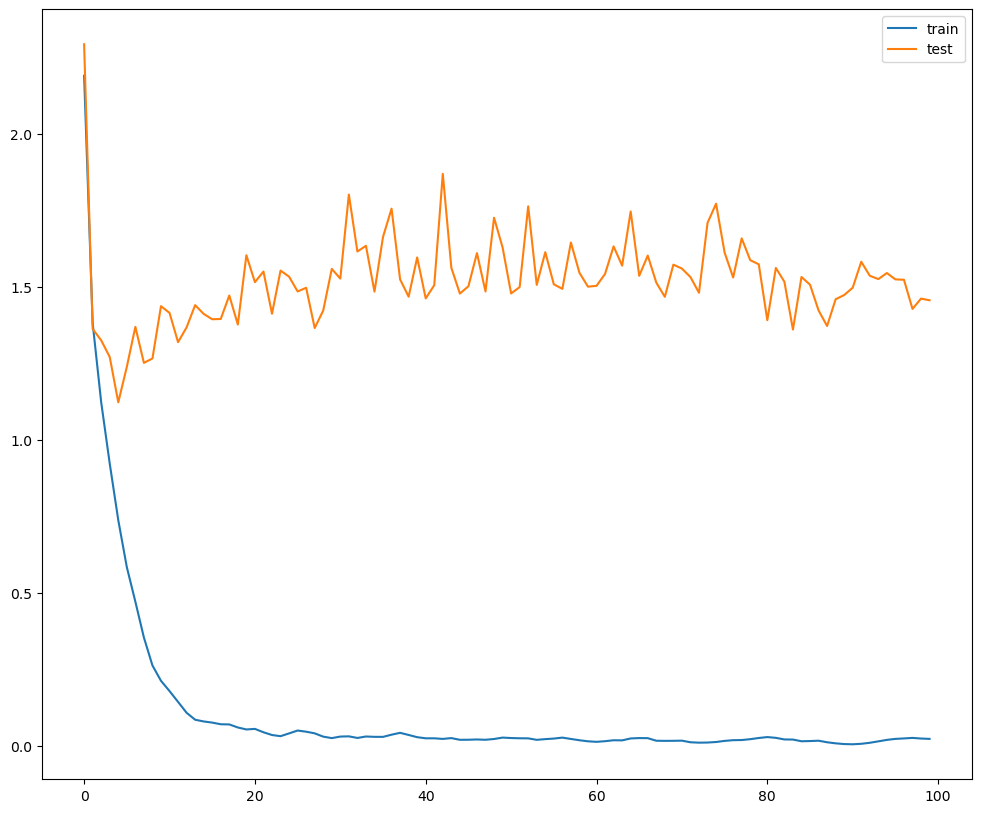

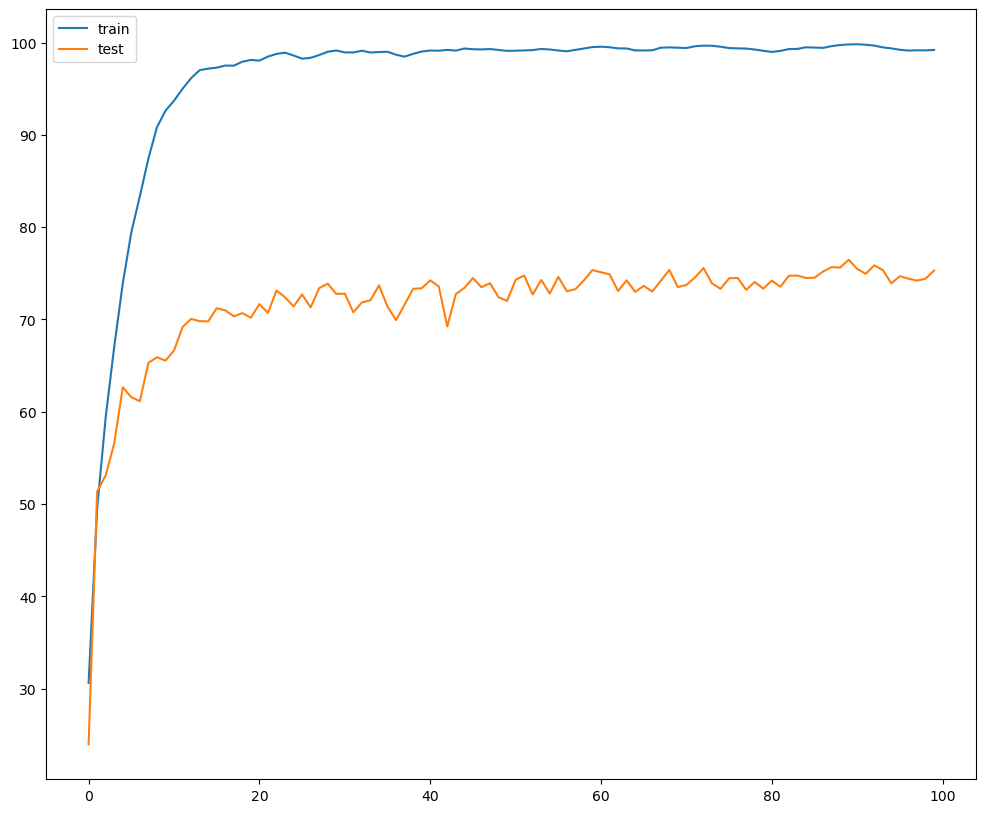

In [3]:
teacher = resnet50(pretrained=False)
teacher_acc,teacher = train(model=teacher,gpu='0,1,2,3,4,5,6,7',fig_name='teacher')
teacher_acc


Epoch 100: Train Loss : 0.000  |  Train Acc : 100.00  |  Test Loss : 0.891  |  Test Acc : 82.47: 100%|██████████| 100/100 [21:22<00:00, 12.83s/it]


82.47


82.47

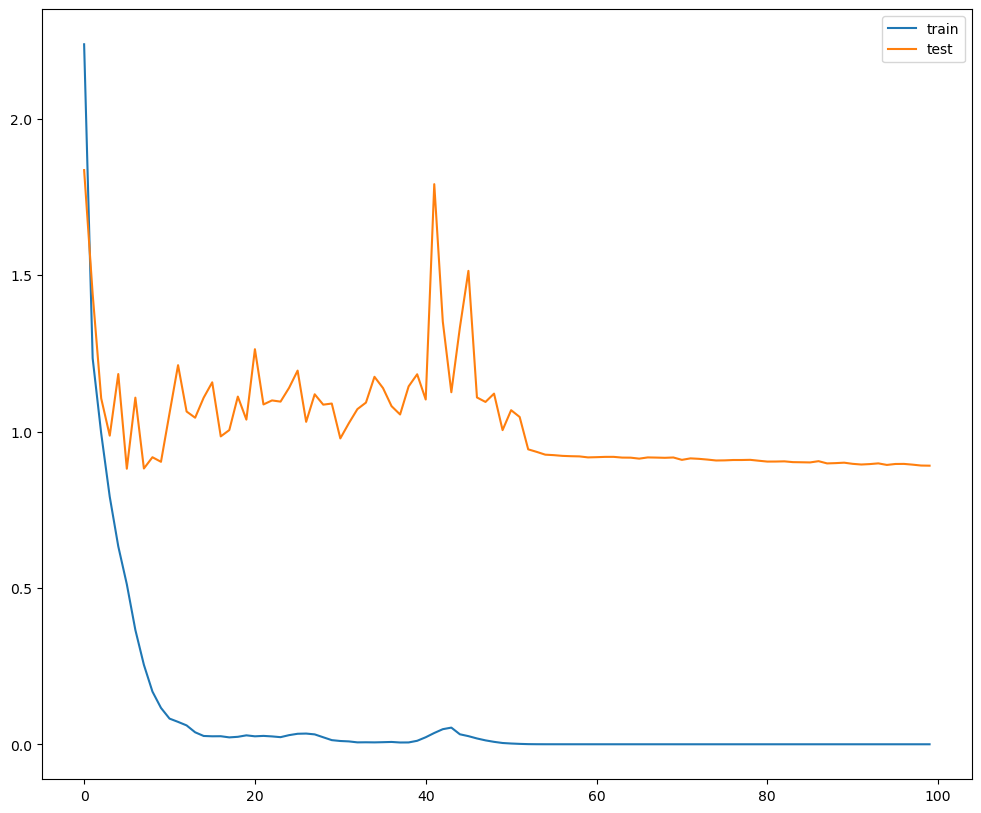

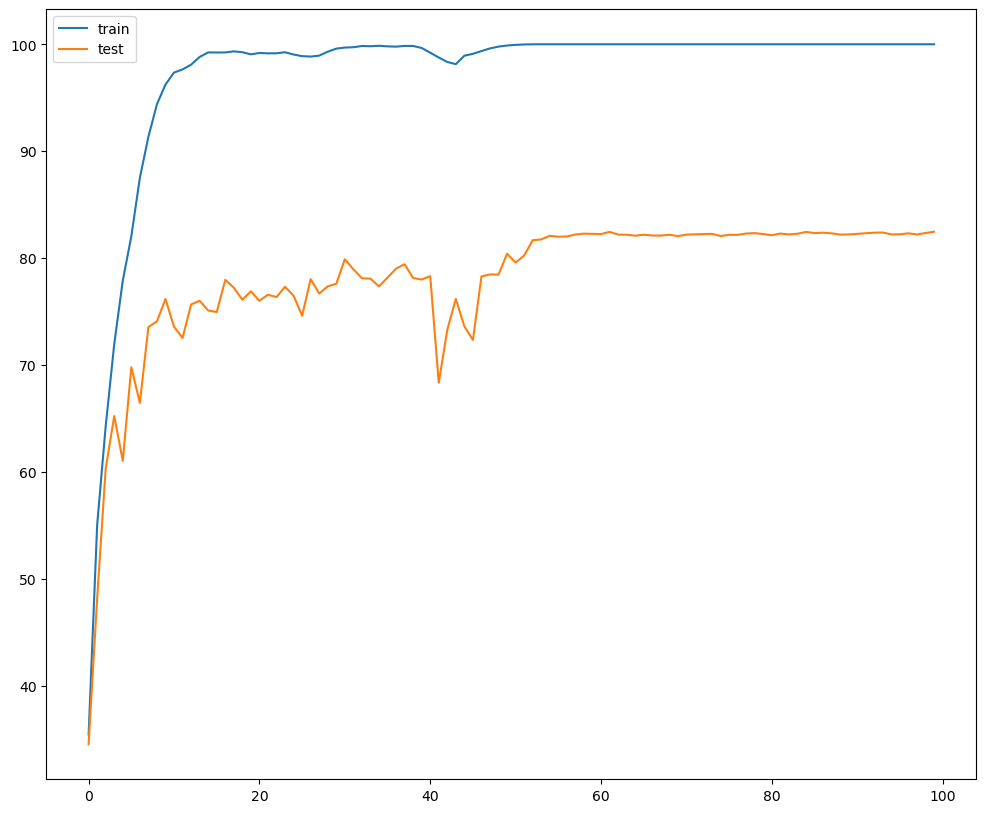

In [4]:
scratch_student = resnet18(pretrained=False)
scratch_student_acc,_ = train(model=scratch_student,gpu='0,1,2,3,4,5,6,7',fig_name='scratch_student')
scratch_student_acc

Epoch 100: Train Loss : 0.000  |  Train Acc : 100.00  |  Test Loss : 2.591  |  Test Acc : 82.24: 100%|██████████| 100/100 [28:17<00:00, 16.98s/it]


82.32000000000001


82.32000000000001

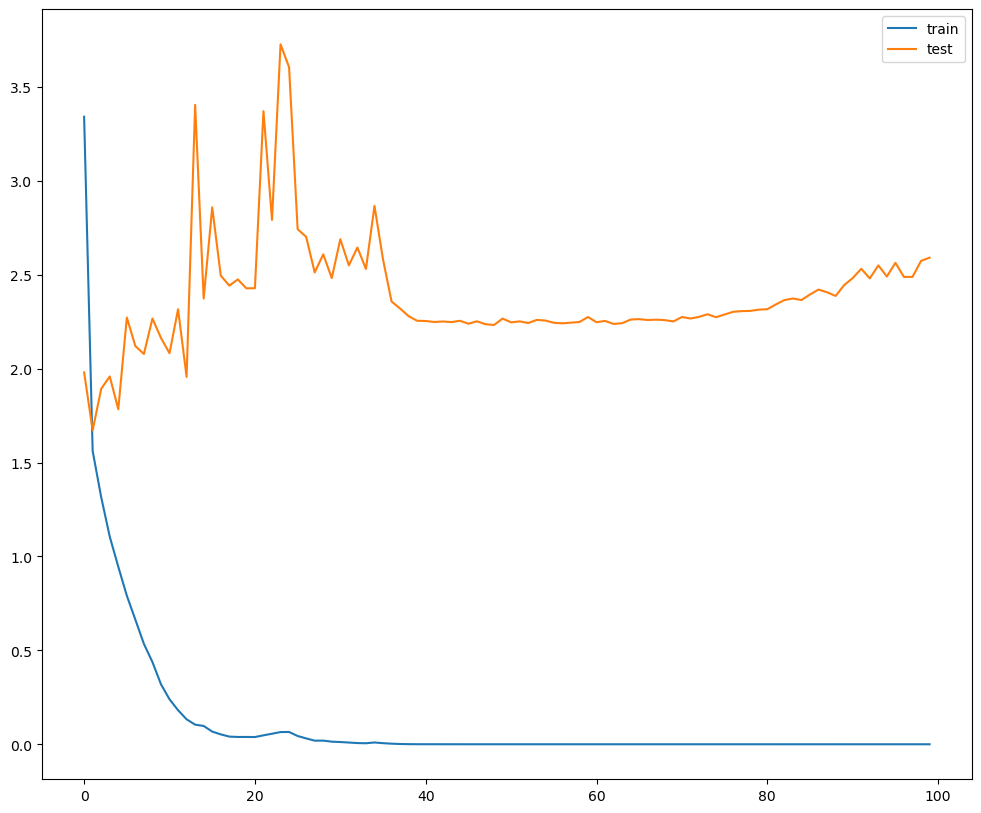

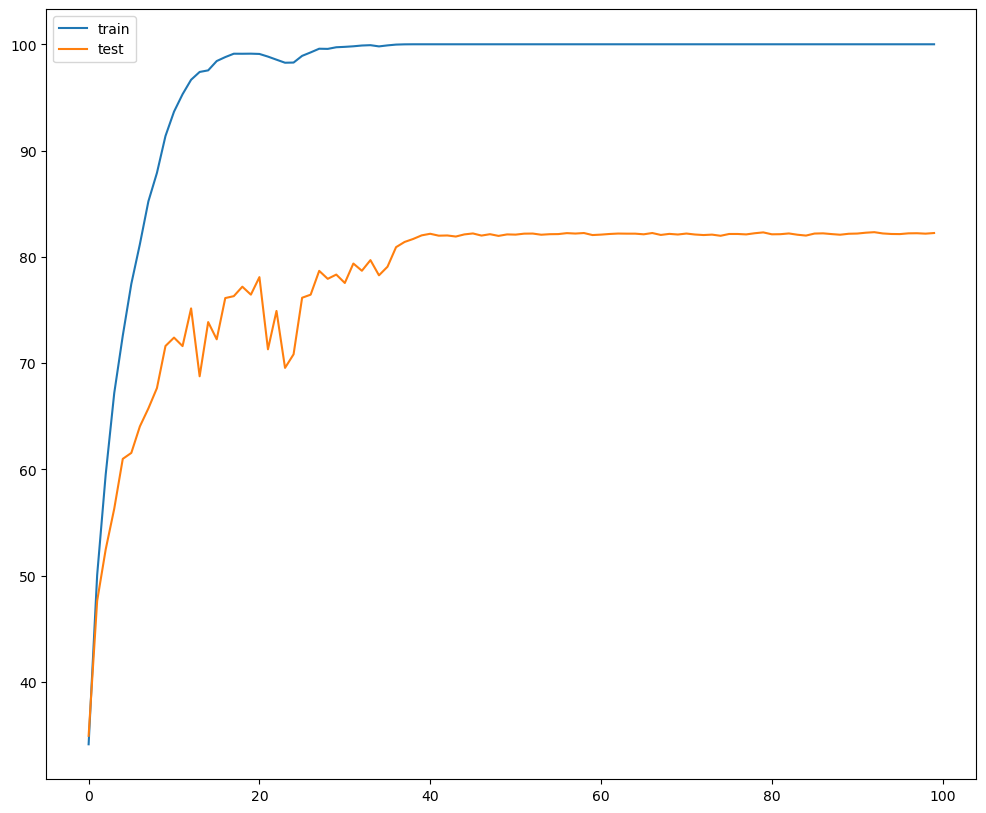

In [17]:
student = resnet18(pretrained=False)
student_acc,_ = train(model=student,gpu='0,1,2,3,4,5,6,7',fig_name='kd_student',kd_tag=True,teacher=teacher)
student_acc

Epoch 100: Train Loss : 0.012  |  Train Acc : 99.62  |  Test Loss : 1.227  |  Test Acc : 78.03: 100%|██████████| 100/100 [25:15<00:00, 15.15s/it]


80.51
80.51


Epoch 100: Train Loss : 0.000  |  Train Acc : 100.00  |  Test Loss : 2.556  |  Test Acc : 82.51: 100%|██████████| 100/100 [27:38<00:00, 16.58s/it]


82.50999999999999
82.50999999999999


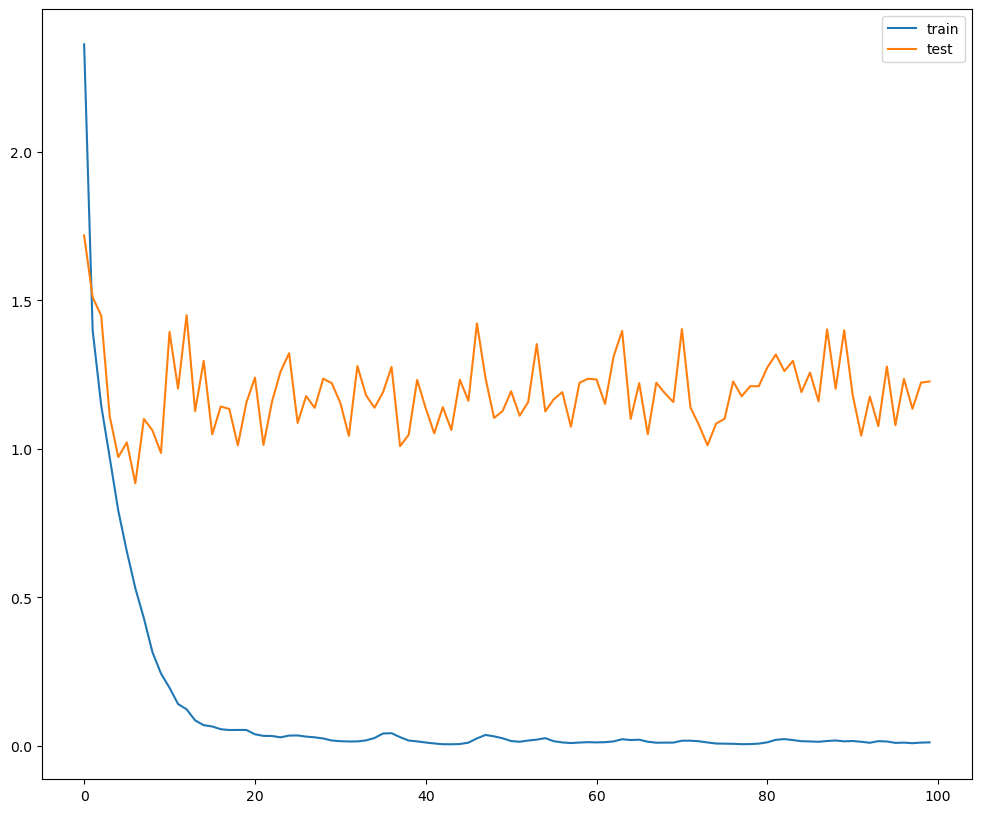

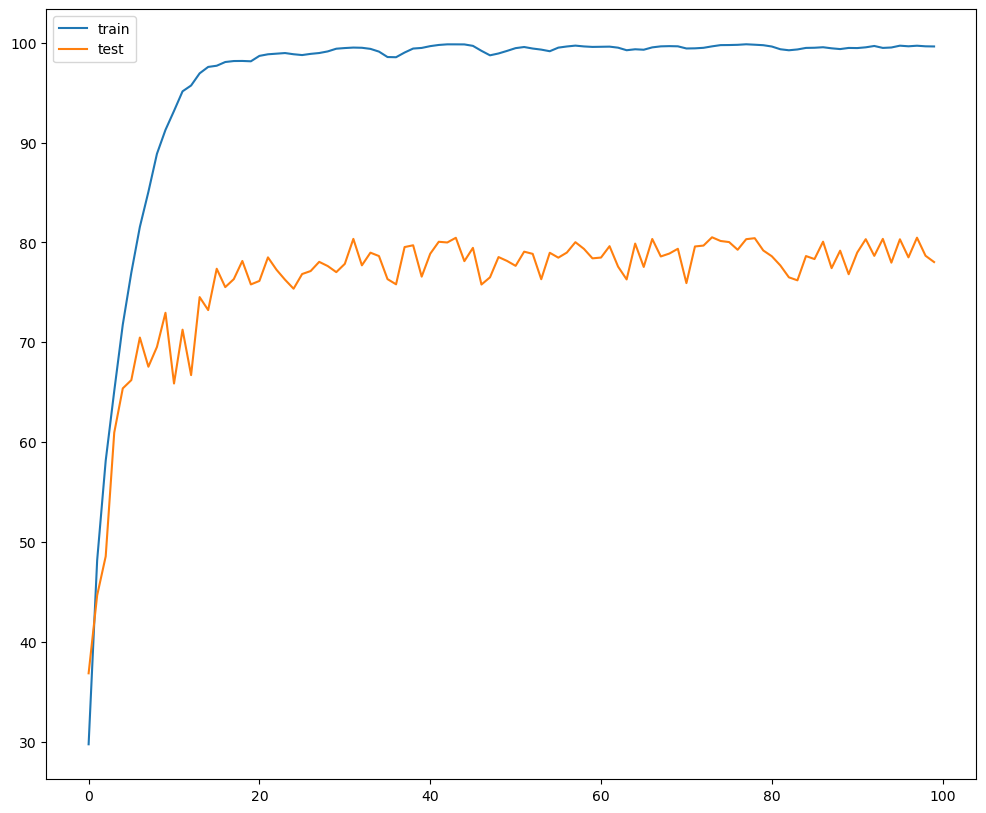

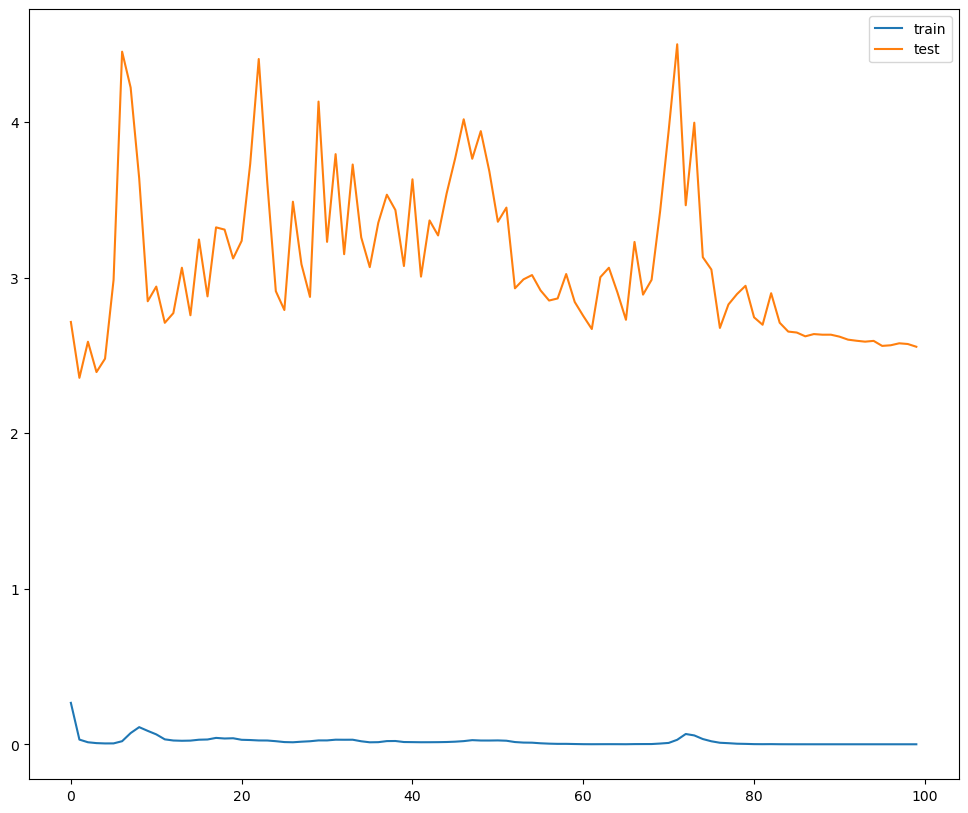

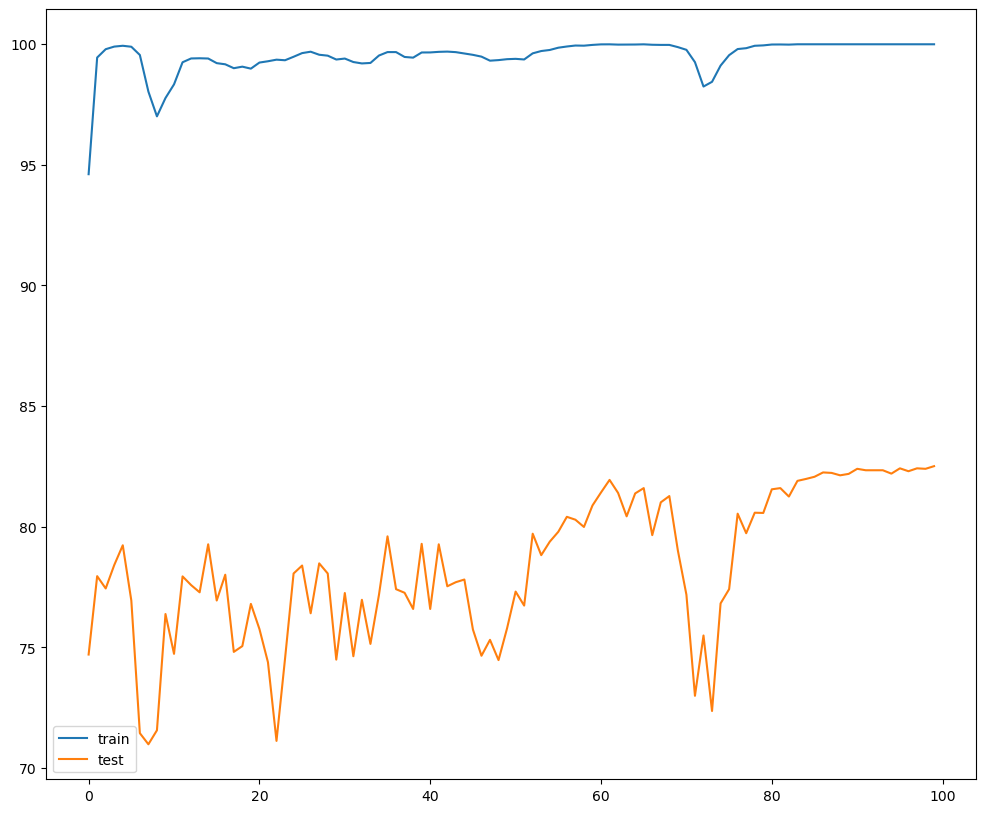

In [18]:
teacher = resnet34(pretrained=False)
teacher_acc,teacher = train(model=teacher,gpu='0,1,2,3,4,5,6,7',fig_name='teacher34')
print(teacher_acc)

student_acc,_ = train(model=student,gpu='0,1,2,3,4,5,6,7',fig_name='kd_student_2',kd_tag=True,teacher=teacher)
print(student_acc)

Epoch 100: Train Loss : 0.011  |  Train Acc : 99.58  |  Test Loss : 1.778  |  Test Acc : 78.36: 100%|██████████| 100/100 [27:25<00:00, 16.46s/it]


80.81


Epoch 100: Train Loss : 0.000  |  Train Acc : 100.00  |  Test Loss : 2.042  |  Test Acc : 82.25: 100%|██████████| 100/100 [26:49<00:00, 16.10s/it]


82.57


Epoch 100: Train Loss : 0.050  |  Train Acc : 98.79  |  Test Loss : 3.083  |  Test Acc : 77.56: 100%|██████████| 100/100 [26:51<00:00, 16.11s/it]


83.47


Epoch 100: Train Loss : 0.000  |  Train Acc : 100.00  |  Test Loss : 3.545  |  Test Acc : 83.42: 100%|██████████| 100/100 [26:54<00:00, 16.15s/it]


83.47


Epoch 100: Train Loss : 0.011  |  Train Acc : 99.83  |  Test Loss : 4.411  |  Test Acc : 80.78: 100%|██████████| 100/100 [26:39<00:00, 16.00s/it]


82.63000000000001


Epoch 100: Train Loss : 0.028  |  Train Acc : 99.58  |  Test Loss : 5.377  |  Test Acc : 80.40: 100%|██████████| 100/100 [26:32<00:00, 15.93s/it]


82.65


Epoch 100: Train Loss : 0.001  |  Train Acc : 100.00  |  Test Loss : 4.879  |  Test Acc : 84.21: 100%|██████████| 100/100 [26:39<00:00, 16.00s/it]


84.21


[80.81, 82.57, 83.47, 83.47, 82.63000000000001, 82.65, 84.21]

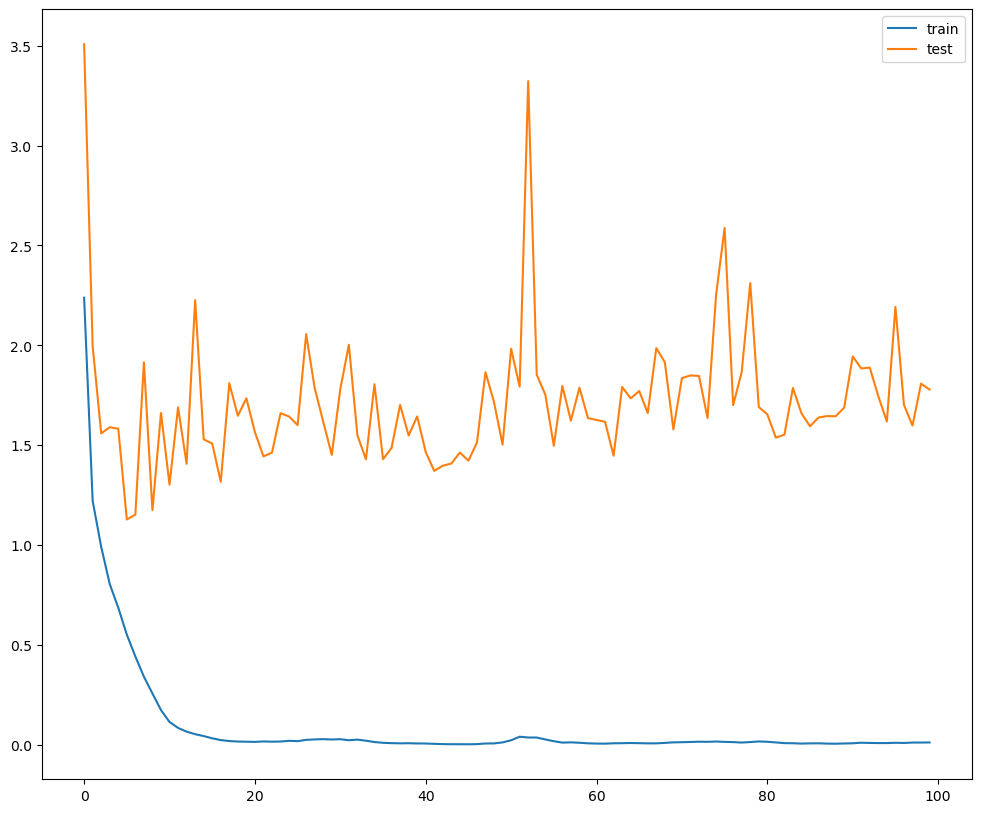

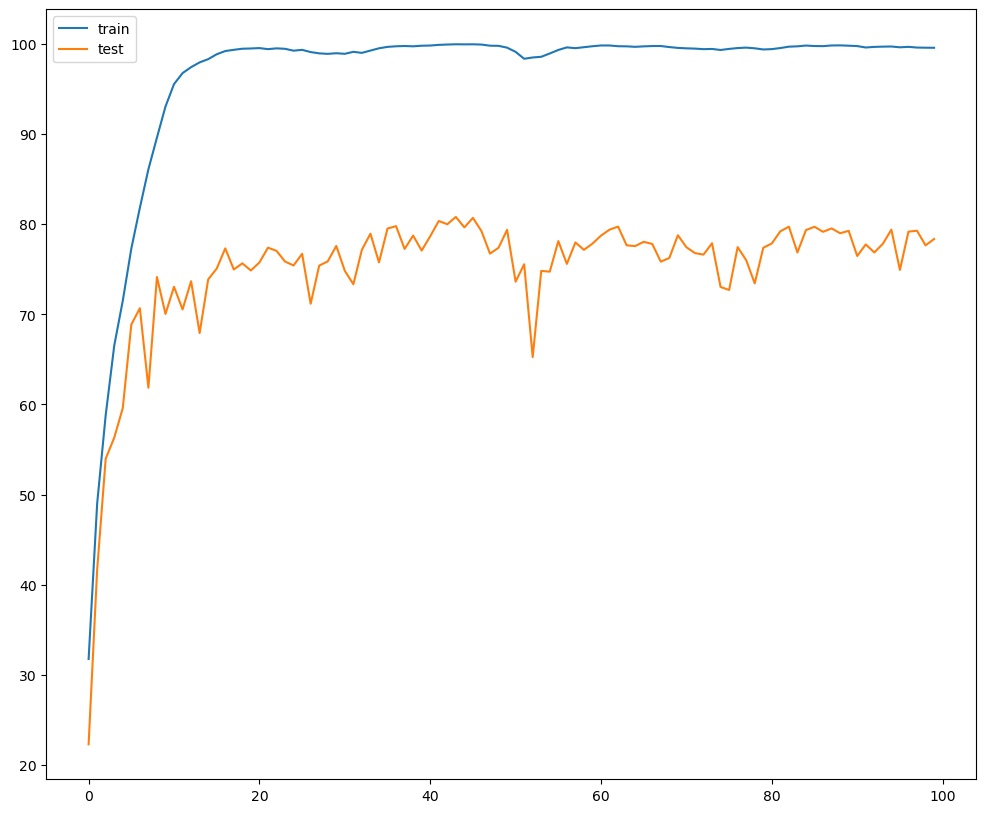

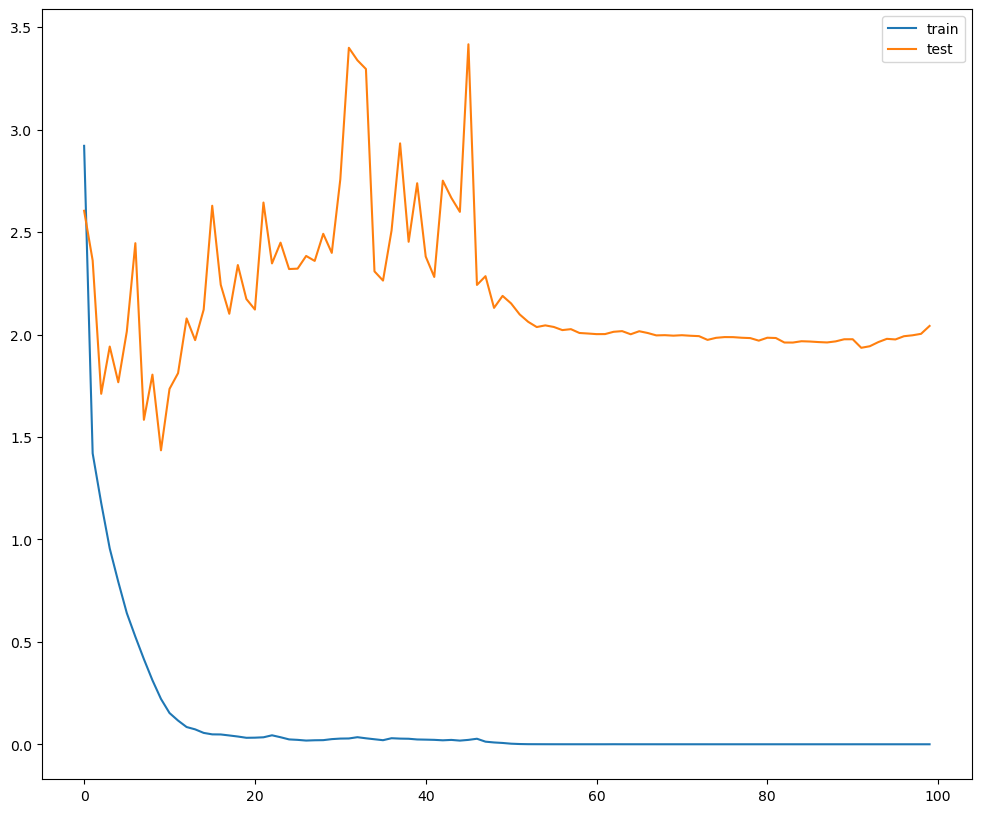

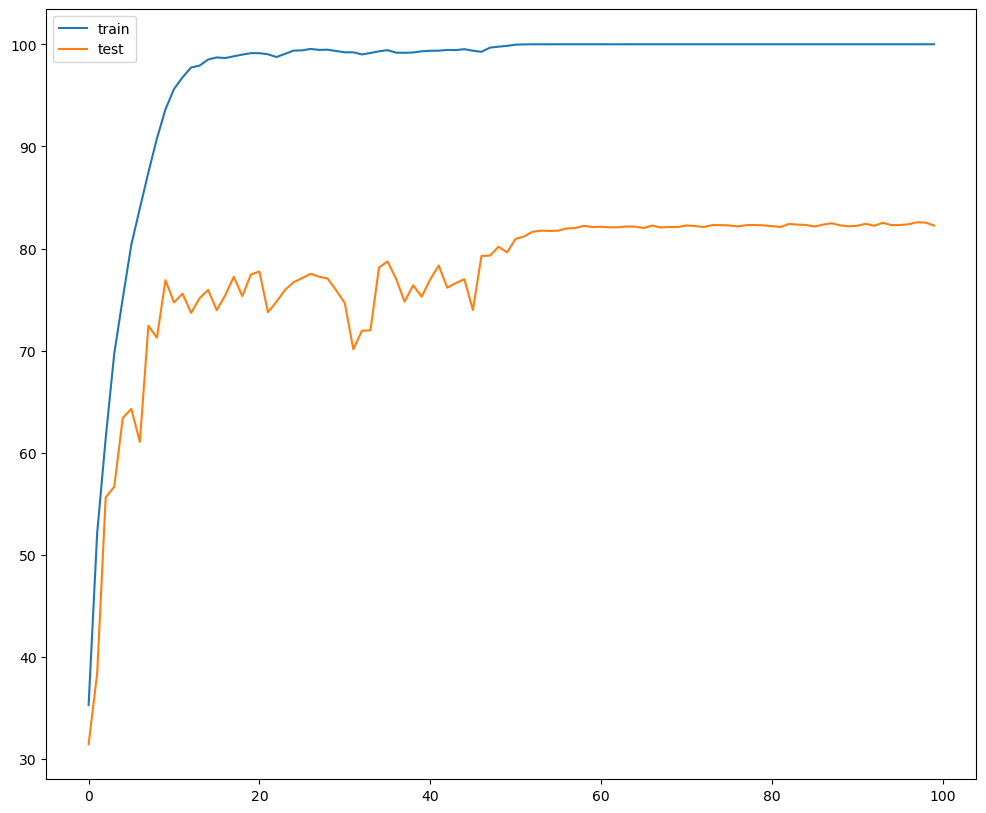

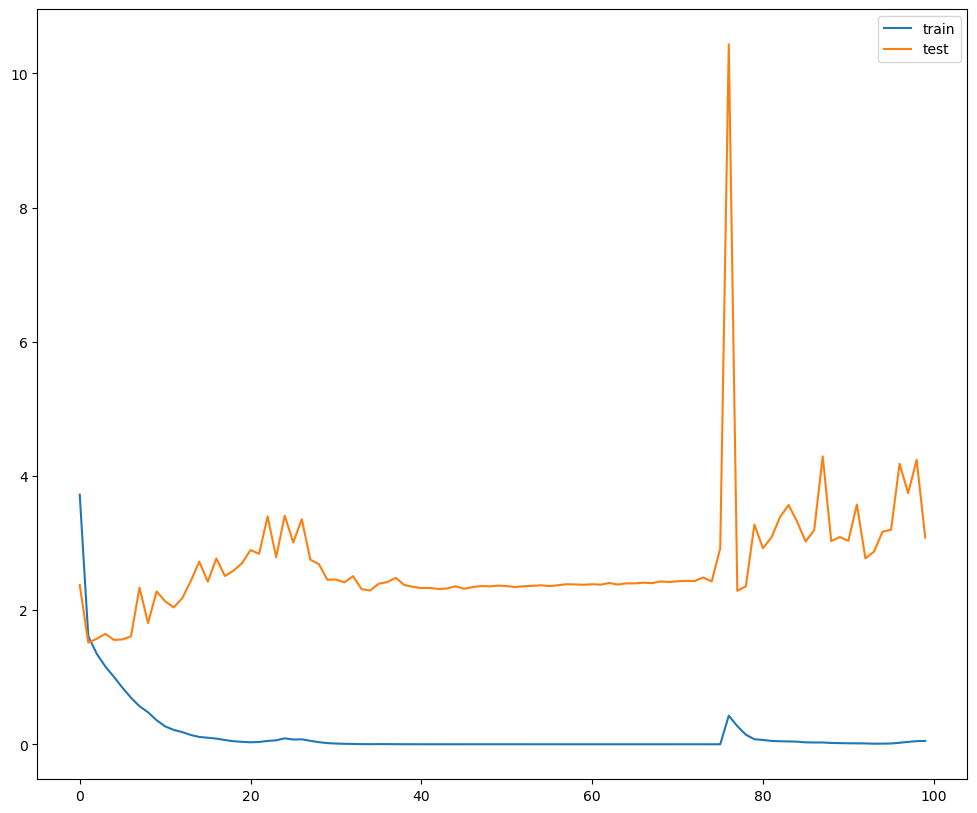

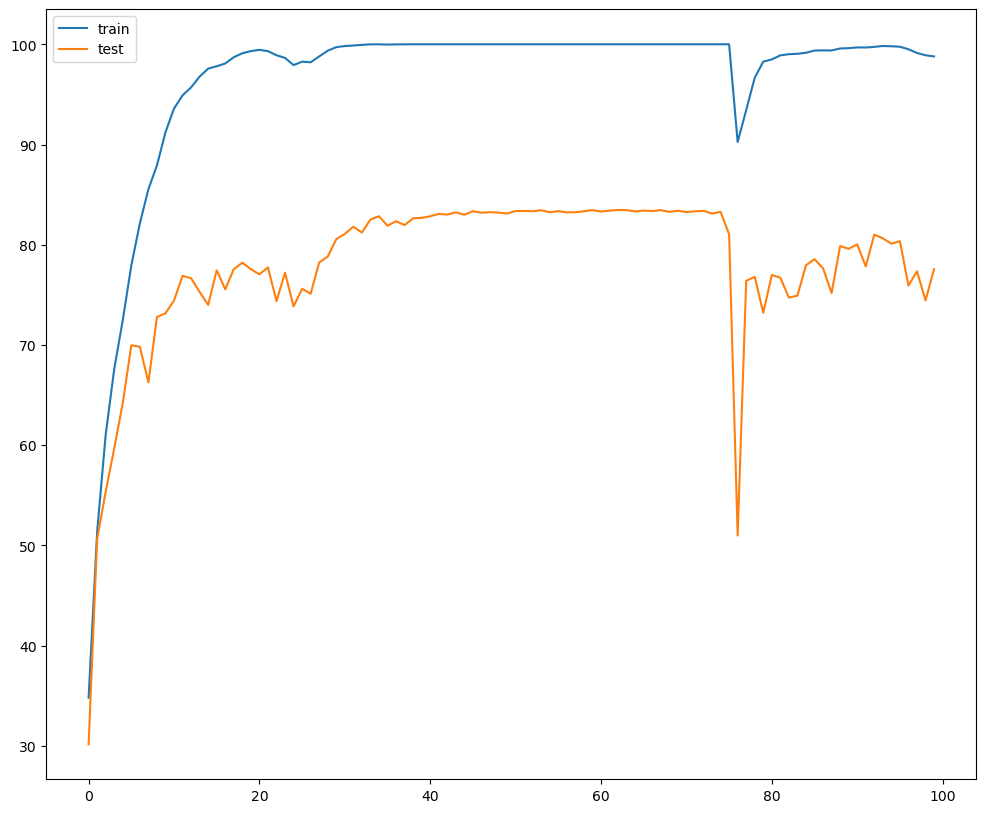

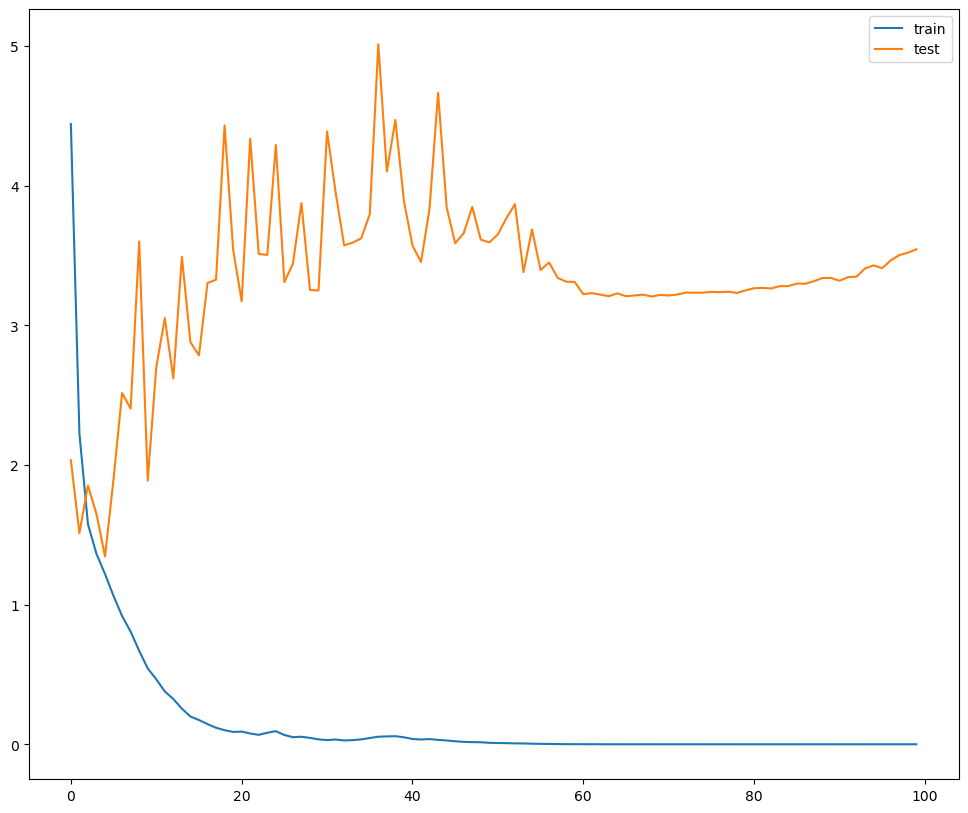

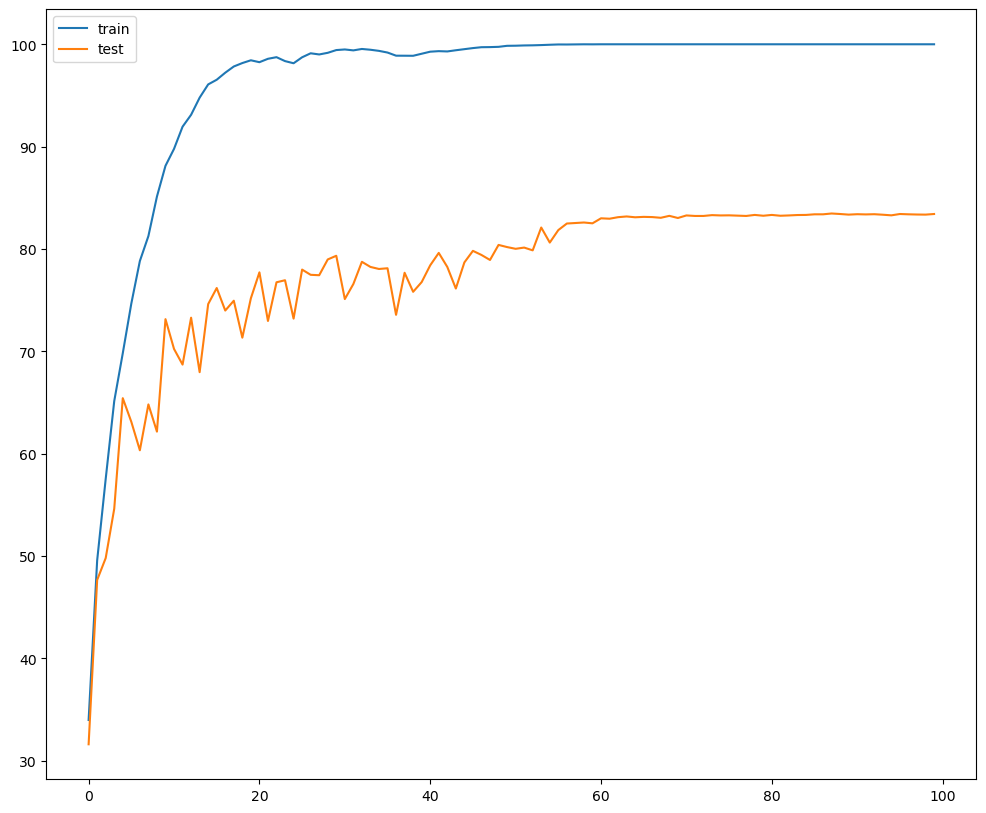

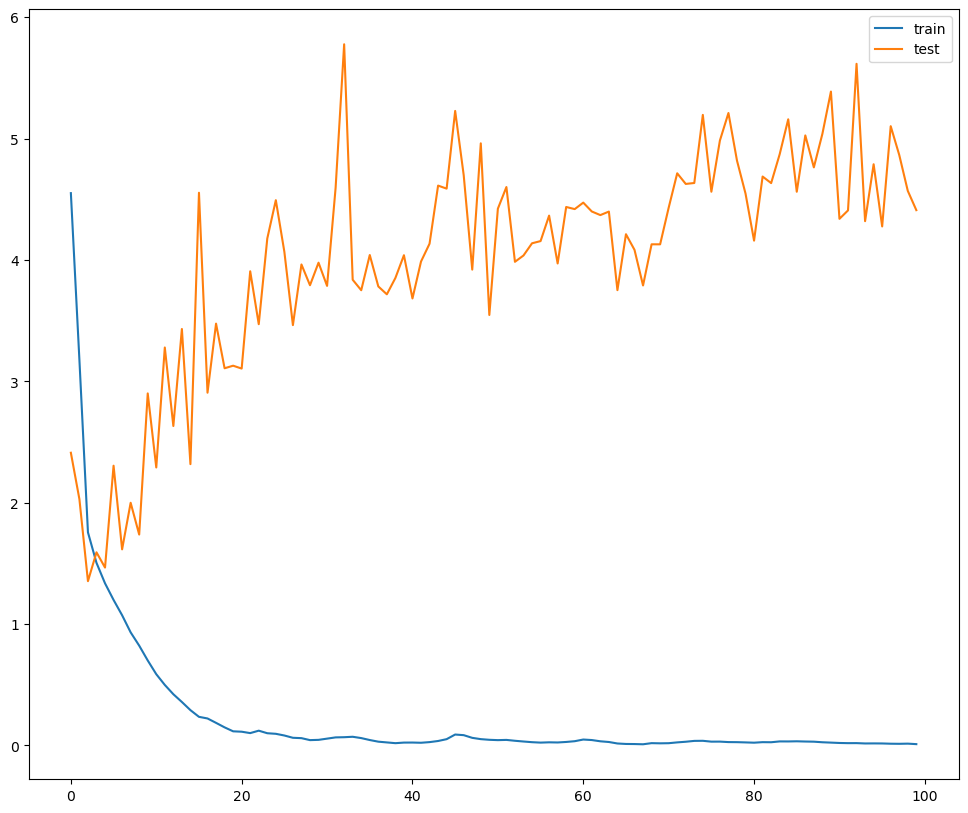

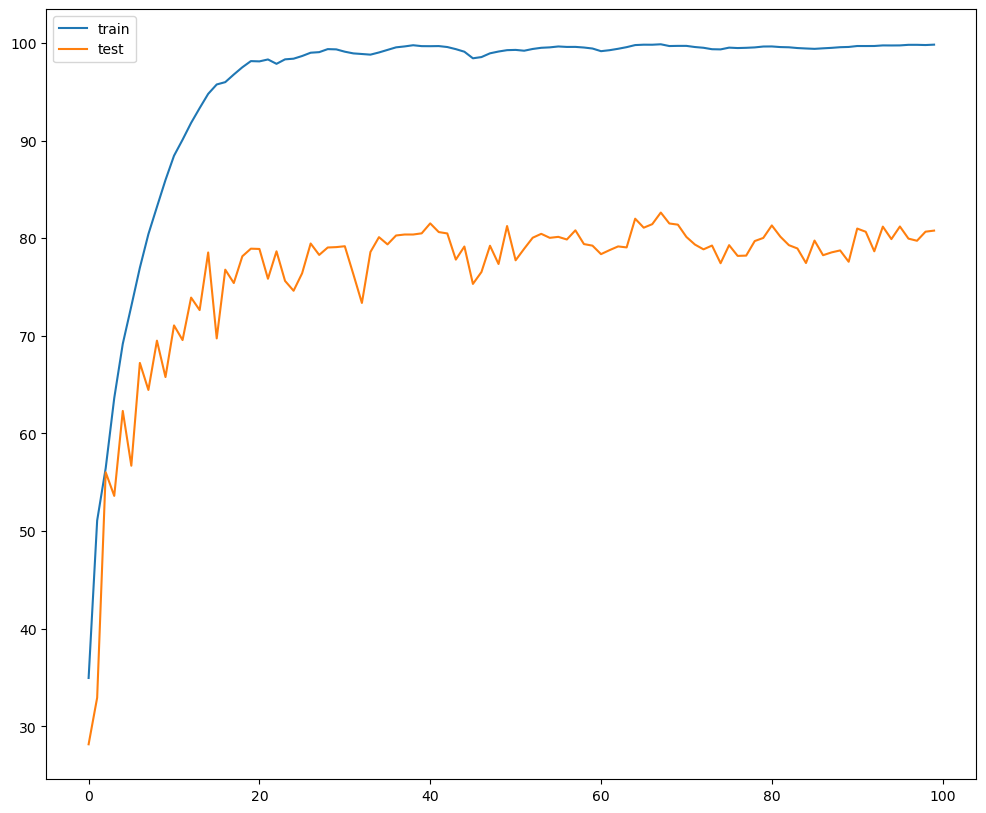

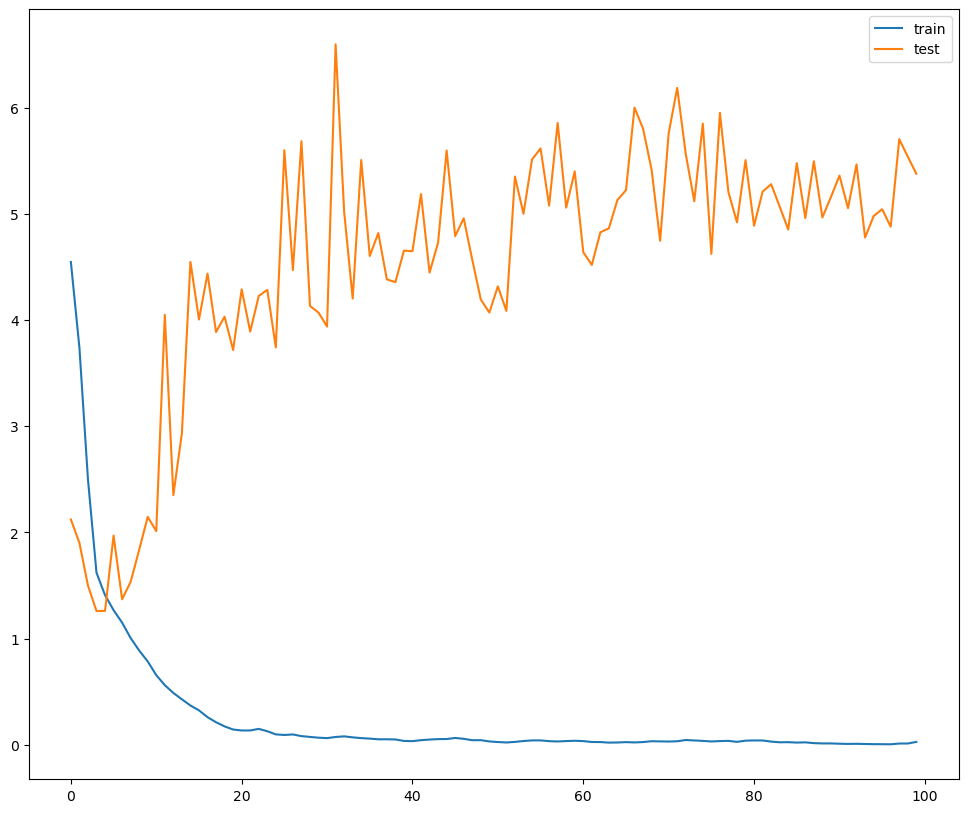

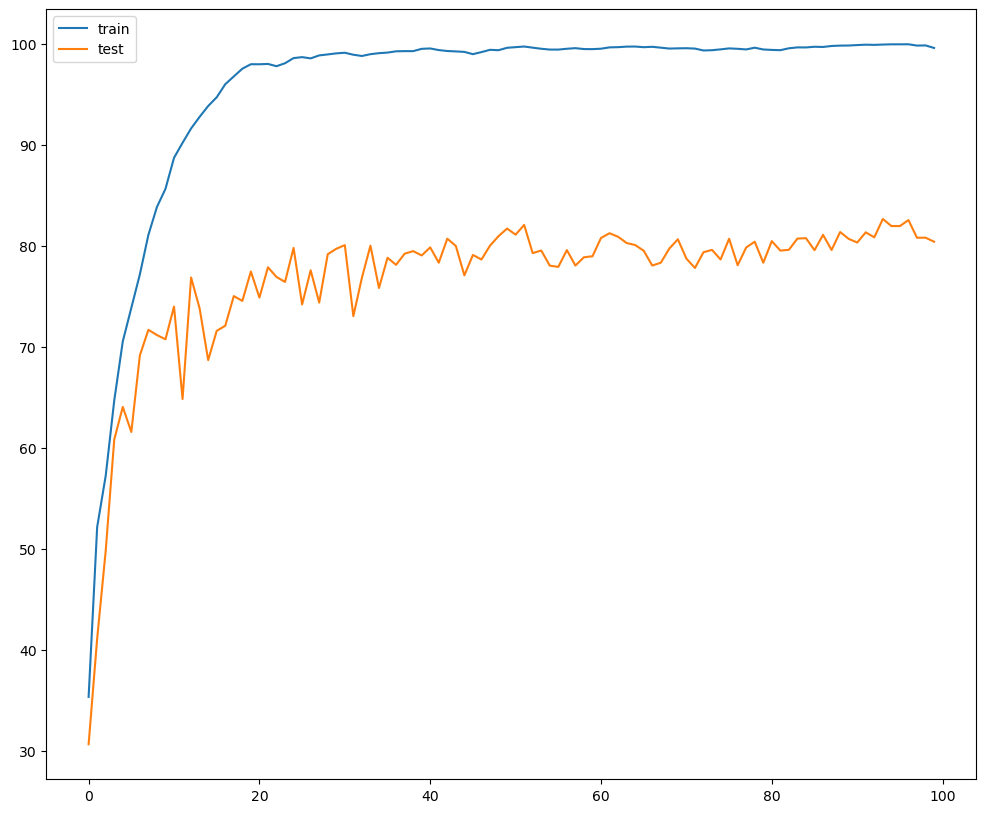

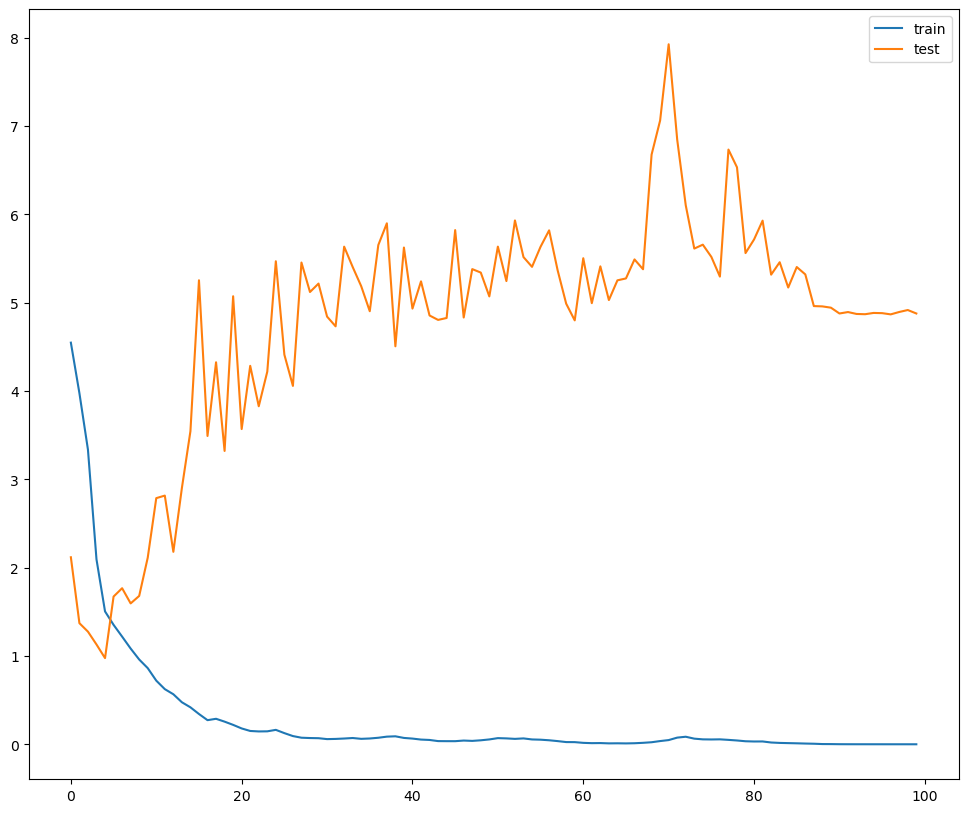

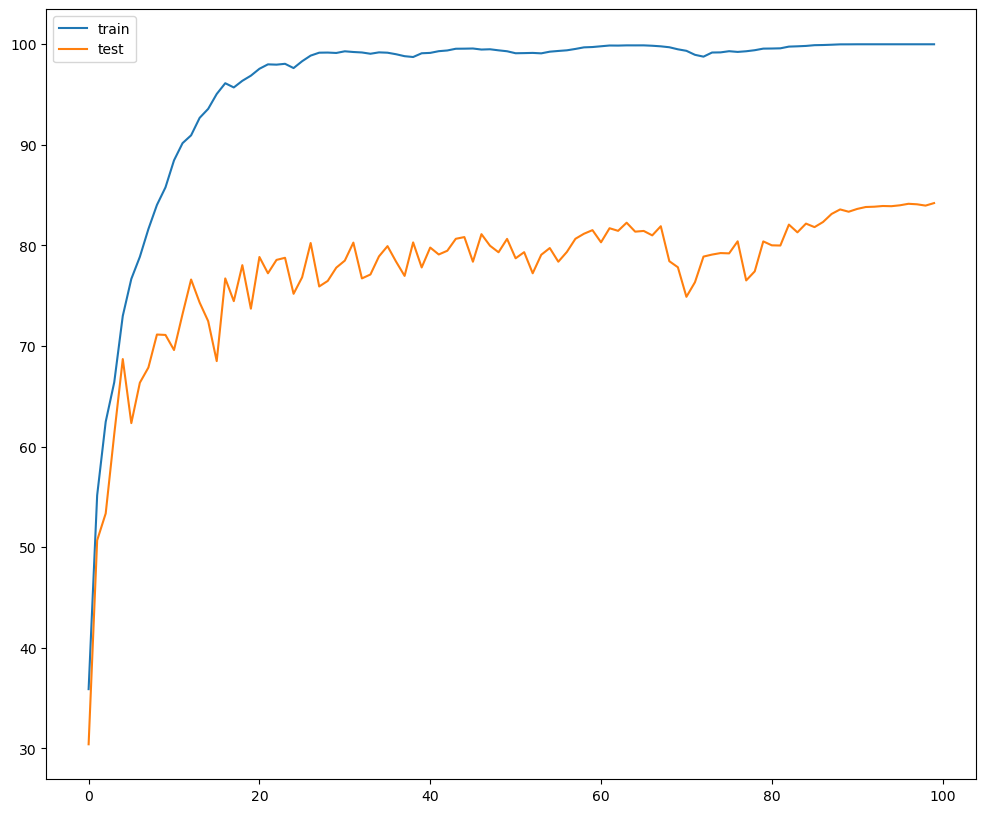

In [19]:
temp_list = list(range(1,8))
acc_list = []
for temp in temp_list:
    student = resnet18(pretrained=False)
    student_acc,_ = train(model=student,gpu='0,1,2,3,4,5,6,7',fig_name=f'student_{temp}',kd_tag=True,teacher=teacher,temp=temp)
    acc_list.append(student_acc)

acc_list

Text(0.5, 1.0, 'acc-temperature')

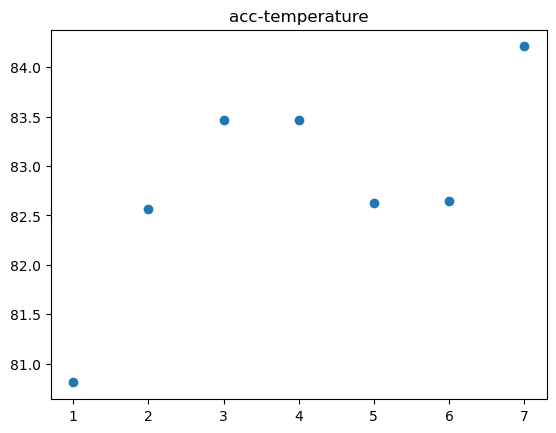

In [20]:
plt.figure()
plt.scatter(temp_list,acc_list)
plt.title('acc-temperature')